In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import proSVD

ModuleNotFoundError: No module named 'proSVD'

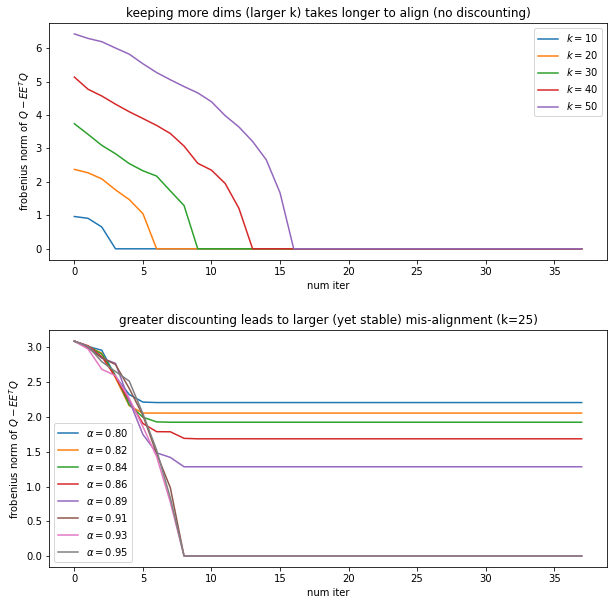

In [2]:
# experiment 6.1 part 1 from overleaf notes

# formalizing the lag analysis - question about what E should look like
# xt=a1cos(ω1t)e1 + a2cos(ω2t) (cos(ωst)e2+ sin(ωst)e3)
a1, a2 = 1, 2
om1, om2, oms = 4, 1, .001

num_steps = 1000
n_dims = 3
embed_dim = 50

def slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0):
    xs = np.zeros((e1.shape[0], num_steps))
    n = np.copy(xs)
    for t in range(num_steps):
        n[:, t] = -np.sin(oms*t)*e2 + np.cos(oms*t)*e3
        noisevec = np.random.normal(loc=0, scale=noisesig, size=(e1.shape[0],))
        xs[:, t] = a1*np.cos(om1*t)*e1 + a2*np.cos(om2*t) * (np.cos(oms*t)*e2 + np.sin(oms*t)*e3) + noisevec
    return xs, n

E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
e1 = E[:, 0]
e2 = E[:, 1]
e3 = E[:, 2]
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=10)

# embedding in higher dimensino
embed_mat = np.random.uniform(size=(embed_dim, n_dims))
embed_xs = np.dot(embed_mat, xs)
E = np.dot(embed_mat, E)
E, R = np.linalg.qr(E) 

l1 = 50
l = 25
decay = 1
k_range = np.arange(10, 60, 10)
num_iters = np.ceil((embed_xs.shape[1] - l1) / l).astype('int')
Q_recon_diff = np.zeros((k_range.shape[0], num_iters))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10), gridspec_kw={'hspace':.3})
for i in range(k_range.shape[0]):
    k = k_range[i]
    Qtcoll, S, Qcoll = get_ssSVD(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    for j in range(num_iters):
        currQ = Qcoll[:, :, j]
        tmp =  (currQ - E.dot(E.T).dot(currQ))
        Q_recon_diff[i, j] = np.linalg.norm(tmp)
    ax1.plot(Q_recon_diff[i, :].T, label=r'$k = $' + '{}'.format(k))

ax1.set(xlabel='num iter', ylabel='frobenius norm of ' + r'$Q - EE^{T}Q$', 
       title='keeping more dims (larger k) takes longer to align (no discounting)')
ax1.legend()

# ----------------------------------------------------------------- #

k = 25
decay_range = np.linspace(.8, .95, num=8)
Q_recon_diff = np.zeros((decay_range.shape[0], num_iters))
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
for i in range(decay_range.shape[0]):
    decay = decay_range[i]
    Qtcoll, S, Qcoll = get_ssSVD(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    for j in range(num_iters):
        currQ = Qcoll[:, :, j]
        tmp =  (currQ - E.dot(E.T).dot(currQ))
        Q_recon_diff[i, j] = np.linalg.norm(tmp)
    ax2.plot(Q_recon_diff[i, :].T, label=r'$\alpha = $' + '{0:.2f}'.format(decay))

ax2.set(xlabel='num iter', ylabel='frobenius norm of ' + r'$Q - EE^{T}Q$', 
       title='greater discounting leads to larger (yet stable) mis-alignment (k=25)')
ax2.legend()

# plt.savefig('Q_alignment_to_ground.png', bbox_inches='tight') 

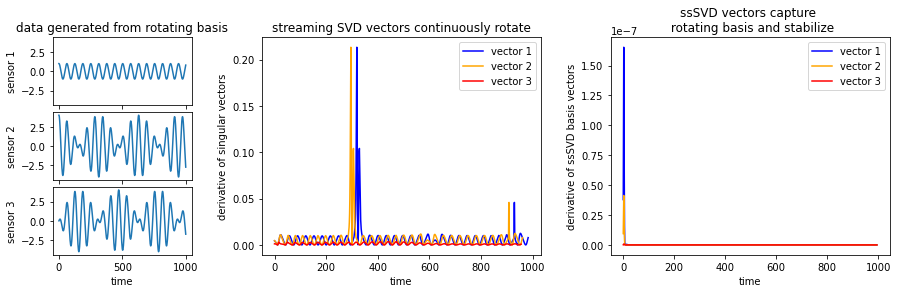

In [3]:
# %%time
# cosyne figure 1

num_steps = 1000
n_dims = 3
embed_dim = 3

a1, a2 = 1, 4
om1, om2, oms = .1, .1, .01

def slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0):
    xs = np.zeros((e1.shape[0], num_steps))
    n = np.copy(xs)
    for t in range(num_steps):
        n[:, t] = -np.sin(oms*t)*e2 + np.cos(oms*t)*e3
        noisevec = np.random.normal(loc=0, scale=noisesig, size=(e1.shape[0],))
        xs[:, t] = a1*np.cos(om1*t)*e1 + a2*np.cos(om2*t) * (np.cos(oms*t)*e2 + np.sin(oms*t)*e3) + noisevec
    return xs, n

# E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
E = np.identity(3)
e1, e2, e3 = E
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0)

# embedding in higher dimensino
# embed_mat = np.random.uniform(size=(embed_dim, n_dims))
# E_embed = np.dot(embed_mat, E)
# E_embed, R = np.linalg.qr(E_embed) 
# embed_xs = np.dot(embed_mat, xs)
embed_xs = xs
# es = np.dot(embed_mat, es)
# embed_xs = np.sum(es, axis=1)

l1 = 3
l = 1
decay = 1
k = 3
num_iters = np.ceil((embed_xs.shape[1] - l1) / l).astype('int')

Qtcoll, Scoll, Qcoll = get_ssSVD(embed_xs, k, l1, l, num_iters, decay_alpha=decay)

# mat_contents = sio.loadmat('IncPACK_experiments/Qcoll.mat')
# Qcoll_seqkl = mat_contents['Qcoll']
QcollU = np.zeros((n_dims, k, num_iters))
ScollU = np.zeros((3, num_iters))
t = 0
for i in range(num_iters):
    U, S, V_T = np.linalg.svd(embed_xs[:, :t+l1+l])
    t = t + l
    currU = U[:, :k]
    QcollU[:, :, i] = currU
    ScollU[:, i] = S
Qcoll_seqkl = QcollU


# plotting
widths = [1.5, 3, 3]
gs_kw = dict(hspace=.1, wspace=.3, width_ratios=widths)
colors = ['blue', 'orange', 'red', 'green']
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 4), sharey='col', sharex='col', gridspec_kw=gs_kw)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for i in range(3):
    for j in range(1,3):
        axs[i, j].remove()
        
axs[0, 0].set_title('data generated from rotating basis')
axs[2, 0].set(xlabel='time')

axbig1 = fig.add_subplot(gs[:, 1])
axbig2 = fig.add_subplot(gs[:, 2])
    
for i in range(3):
    axs[i, 0].plot(embed_xs[i, :])
    axs[i, 0].set(ylabel='sensor {}'.format(i+1))
    

deriv = Qcoll[:, :, 1:] - Qcoll[:, :, :-1]
deriv = np.linalg.norm(deriv, axis=1)
for i in range(n_dims):
#     smooth_deriv = gaussian_filter1d(deriv[i, :], sigma=2)
    smooth_deriv = deriv[i, :]
    axbig2.plot(smooth_deriv, c=colors[i], label='vector ' + '{}'.format(i+1))
axbig2.set(title='ssSVD vectors capture \n rotating basis and stabilize',
       xlabel='time', ylabel=r'derivative of ssSVD basis vectors')
axbig2.legend()

deriv_seqkl = Qcoll_seqkl[:, :, 1:] - Qcoll_seqkl[:, :, :-1]
deriv_seqkl = np.linalg.norm(deriv_seqkl, axis=0)
for i in range(3):
#     smoothed_deriv = gaussian_filter1d(deriv_seqkl[i, :], sigma=2)
    smoothed_deriv = deriv_seqkl[i, :]
    axbig1.plot(smoothed_deriv[smoothed_deriv < 1], c=colors[i], label='vector ' + '{}'.format(i+1))
axbig1.set(title='streaming SVD vectors continuously rotate', 
           xlabel='time', ylabel='derivative of singular vectors')
axbig1.legend(loc='upper right')

# axbig1.set(ylim=(0, .05))
# axbig2.set(ylim=(0, .05))

# plt.savefig('figures/cosyne2021/fig1.svg', bbox_inches='tight')

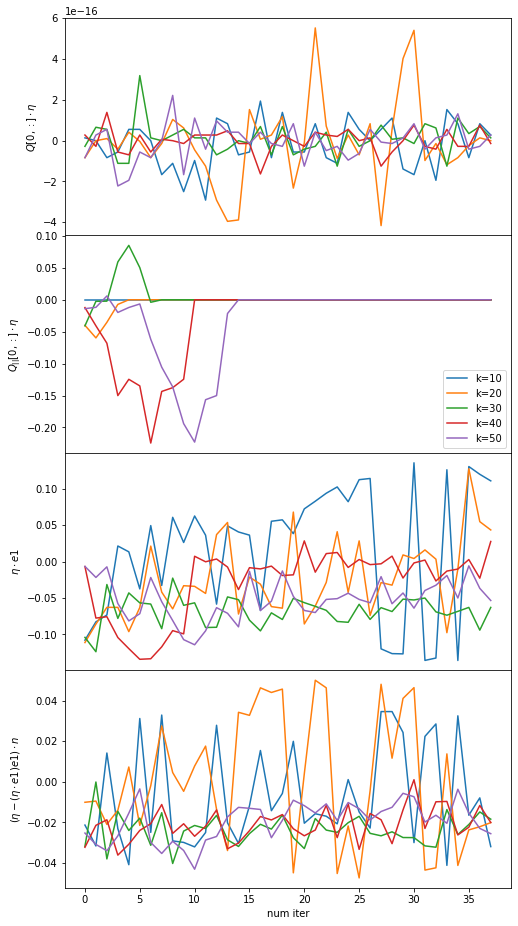

In [4]:
# experiment 6.1 part 2 - TODO: comparisons with other methods (regular svd to start)

a1, a2 = 1, 2
om1, om2, oms = 4, 1, .0001
num_steps = 1000
n_dims = 50
embed_dim = 50

E, R = np.linalg.qr(np.random.uniform(size=(n_dims,3)))
# E = np.random.uniform(size=(n_dims, 3))
e1 = E[:, 0]
e2 = E[:, 1]
e3 = E[:, 2]
xs, n = slowly_changing_basis(num_steps, e1, e2, e3, noisesig=0)

embed_mat = np.random.uniform(size=(embed_dim, n_dims))
embed_xs = np.dot(embed_mat, xs)
E = np.dot(embed_mat, E)
E, R = np.linalg.qr(E)

l1 = 50
l = 25
decay = 1
k_range = np.arange(10, 60, 10)
num_iters = np.ceil((embed_xs.shape[1] - l1) / l).astype('int')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8, 16), sharex=True, gridspec_kw={'hspace':0})
for j in range(k_range.shape[0]):
    k = k_range[j]
    Qtcoll, S, Qcoll = get_ssSVD(embed_xs, k, l1, l, num_iters, decay_alpha=decay)
    Qprojeta = np.zeros((10, Qcoll.shape[2]))
    Qeta = np.copy(Qprojeta)
    etae1 = np.zeros((Qcoll.shape[2]))
    ang_around_axis = np.zeros((Qcoll.shape[2]))
    for i in range(Qcoll.shape[2]):
        Q = Qcoll[:, :10, i]
        Z = scipy.linalg.null_space(Q.T)
        eta = Z[:, 0]
        Qproj = E.dot(E.T).dot(Q)
        Qprojeta[:, i] = Qproj.T.dot(eta)
        Qeta[:, i] = Q.T.dot(eta)
        etae1[i] = np.dot(eta, e1)
        ang_around_axis[i] = ((eta - np.dot(eta, e1)) * e1).dot(n[:, i])

    ax2.plot(Qprojeta[0, :], label='k={}'.format(k))
    ax1.plot(Qeta[0, :])
    ax3.plot(etae1)
    ax4.plot(ang_around_axis)

ax2.set(ylabel=r'$Q_{||}[0,:] \cdot \eta $')
ax1.set(ylabel=r'$Q[0,:] \cdot \eta$')
ax3.set(ylabel=r'$\eta \cdot e1$')
ax4.set(xlabel='num iter', ylabel=r'$(\eta - (\eta \cdot e1)e1) \cdot n$')

ax2.legend()
# plt.savefig('Q_lag_to_ground.png', bbox_inches='tight')

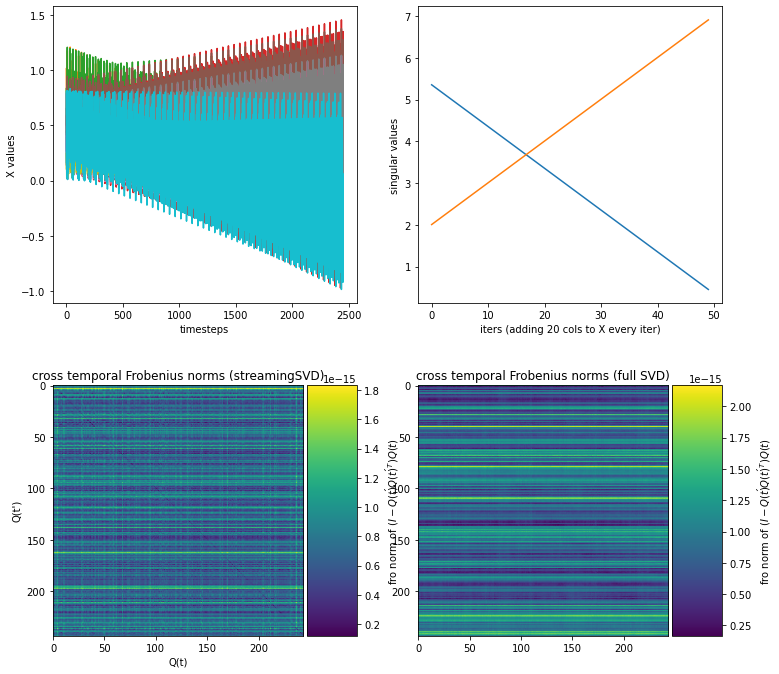

In [5]:
# %%time
# experiment 6.2 - TODO: NOT WORKING, generate change in sing vals differently

# flipping singular vals - question about the shapes (doing not real svd now)
# try determinant instead of fro norm
# check power
num_steps = 50
n_dims = 2
embed_dim = 10

A = np.random.uniform(size=(n_dims, num_steps))
U, curr_S, V_T = np.linalg.svd(A, full_matrices=False)

# X1 = U.dot(np.diag(S)).dot(V_T)
# X2 = U.dot(np.diag(np.flip(S))).dot(V_T)
# X = np.append(X1, X2, axis=1)

X = np.array([[], []])
all_S = np.zeros((n_dims, num_steps))
all_S[:, 0] = curr_S
for t in range(1, num_steps):
    all_S[:, t] = all_S[:, t-1] + [-0.1, 0.1]
    curr_X = U.dot(np.diag(all_S[:, t])).dot(V_T)
    X = np.append(X, curr_X, axis=1)
    
# embedding
embed_mat = np.random.uniform(size=(embed_dim, n_dims))
X = np.dot(embed_mat, X)

k = 2
l1 = 10
l = 10
decay = .95
num_iters = np.ceil((X.shape[1] - l1) / l).astype('int')
Qtcoll, S, Qcoll = get_ssSVD(X, k, l1, l, num_iters, decay_alpha=decay)
# Qtcoll1, S1, Qcoll1 = getSvd(X, k, l1, l, num_iters, decay_alpha=decay, norm='l1')

# # regular svd
k = 2
l = 10
t = 0
num_iters = np.ceil((X.shape[1] - l) / l).astype('int')

QcollU = np.zeros((X.shape[0], k, num_iters))
for i in range(num_iters):
    U, S, V_T = np.linalg.svd(X[:, t:t+l])
    t = t + l
    currU = U[:, :k]
    QcollU[:, :, i] = currU

cross_temp_norms = np.zeros((num_iters, num_iters))
for i in range(num_iters):
    for j in range(num_iters):
        Qprime = QcollU[:, :, i]
        Q = QcollU[:, :, j]
        tmp = (np.identity(10) - Qprime.dot(Qprime.T)).dot(Q)
        cross_temp_norms[i, j] = np.linalg.norm(tmp)     

# plotting
fig, axarr = plt.subplots(2, 2, figsize=(12, 12))

axarr[0, 0].plot(X.T)
axarr[0, 0].set(xlabel='timesteps', ylabel='X values')

axarr[0, 1].plot(all_S.T)
axarr[0, 1].set(xlabel='iters (adding 20 cols to X every iter)', ylabel='singular values')

im = axarr[1, 0].imshow(cross_temp_norms)
axarr[1, 0].set(xlabel='Q(t)', ylabel='Q(t\')', title='cross temporal Frobenius norms (streamingSVD)')
divider = make_axes_locatable(axarr[1, 0])
cax = divider.append_axes("right", size="20%", pad=.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('fro norm of ' + r'$(I - Q(t\')Q(t\')^T)Q(t)$')#, rotation=270)


cross_temp_norms = np.zeros((num_iters, num_iters))
for i in range(num_iters):
    for j in range(num_iters):
        Qprime = Qcoll[:, :, i]
        Q = Qcoll[:, :, j]
        tmp = (np.identity(embed_dim) - Qprime.dot(Qprime.T)).dot(Q)
        cross_temp_norms[i, j] = np.linalg.norm(tmp)  
        
im = axarr[1, 1].imshow(cross_temp_norms)
divider = make_axes_locatable(axarr[1, 1])
cax = divider.append_axes("right", size="20%", pad=.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('fro norm of ' + r'$(I - Q(t\')Q(t\')^T)Q(t)$')#, rotation=270)
axarr[1, 1].set(title='cross temporal Frobenius norms (full SVD)')
# sum j lambda_j * u_j * v_j
# sum j u_j * (lambda_j * v_j)

# plt.savefig('figures/Q_flipping_svs.png', bbox_inches='tight')
plt.show()

[Text(0, 0.5, 'ssSVD singular values'), Text(0.5, 0, 'time')]

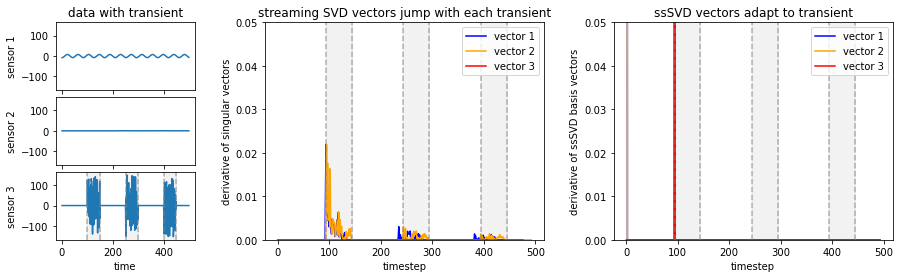

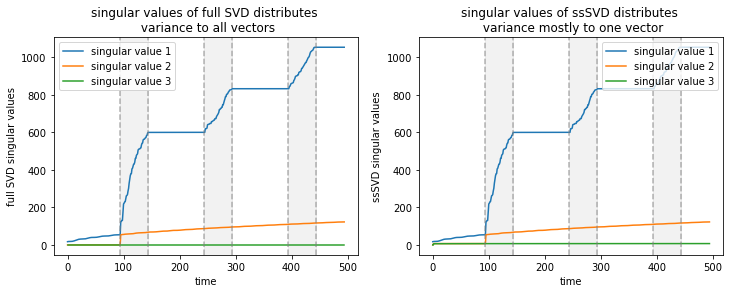

In [6]:
# %%time
# experiment 6.3 - transients that dominate variance
# xt = a1cos(ω1t)e1 + a2cos(ω2t)e2 + b(t)e4
n_dims = 3
embed_dims = 4
a1, a2 = 5, 6
om1, om2 = .15, .15
num_steps = 500

k = 3
l1 = 5
l = 1
decay = 1
num_iters = np.ceil((num_steps - l1) / l).astype('int')

transients = [(100, 150), (250, 300), (400, 450)]
bs = np.zeros((num_steps))
for i in range(len(transients)):
    start, end = transients[i]
    bs[start:end] = np.random.uniform(-200, 200, size=(end - start)) # magnitude higher than a_j

E, R = np.linalg.qr(np.random.uniform(size=(n_dims,4)))
# E = np.identity(n_dims)
e1, e2, e4 = E
es = np.zeros((n_dims, 3, num_steps))
for t in range(num_steps):
    es[:, :, t] = [a1*np.cos(om1*t)*e1, a2*np.cos(om2*t)*e2, bs[t]*e4]
xs = np.sum(es, axis=1)

# embedding in higher dimension
# embed_mat = np.random.uniform(size=(embed_dim, n_dims))
# E_embed = np.dot(embed_mat, E)
# E_embed, R = np.linalg.qr(E_embed) 
# embed_xs = np.dot(embed_mat, xs)
# xs = embed_xs

Qtcoll, Scoll, Qcoll = get_ssSVD(xs, k, l1, l, num_iters, decay_alpha=decay, silent=True)

QcollU = np.zeros((n_dims, k, num_iters))
ScollU = np.zeros((n_dims, num_iters))
t = 0
for i in range(num_iters):
    U, S, V_T = np.linalg.svd(xs[:, :t+l1+l])
    t = t + l
    currU = U[:, :k]
    QcollU[:, :, i] = currU
    ScollU[:, i] = S
    
    
# plotting
widths = [1.5, 3, 3]
gs_kw = dict(hspace=.1, wspace=.3, width_ratios=widths)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 4), sharey='col', sharex='col', gridspec_kw=gs_kw)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for i in range(3):
    for j in range(1,3):
        axs[i, j].remove()
        
axs[0, 0].set_title('data with transient')
axs[2, 0].set(xlabel='time')

axbig1 = fig.add_subplot(gs[:, 1])
axbig2 = fig.add_subplot(gs[:, 2])
    
for i in range(xs.shape[0]):
    axs[i, 0].plot(xs[i, :])
    axs[i, 0].set(ylabel='sensor {}'.format(i+1))
    
colors = ['blue', 'orange', 'red', 'green']
for i in range(3):
    Qvecs = Qcoll[:, i, :]
    Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
    Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
    axbig2.plot(Qvecs_dists[Qvecs_dists < 1], color=colors[i], label='vector {}'.format(i+1))
    axbig2.set(title='ssSVD vectors adapt to transient',
               ylabel='derivative of ssSVD basis vectors', xlabel='timestep')
    
    Qvecs = QcollU[:, i, :]
    Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
    Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
    axbig1.plot(Qvecs_dists[Qvecs_dists < 1], color=colors[i], label='vector {}'.format(i+1))
    axbig1.set(title='streaming SVD vectors jump with each transient',
               ylabel='derivative of singular vectors', xlabel='timestep')
    
axbig1.legend(loc='upper right')
axbig2.legend(loc='upper right')


# greying transients
for start, end in transients:
    axs[2, 0].axvspan(start, end, alpha=.1, color='gray')
    axs[2, 0].axvline(start, alpha=.6, color='gray', ls='--')
    axs[2, 0].axvline(end, alpha=.6, color='gray', ls='--')

for start, end in transients:
    start -= l1 + 1
    end -= l1 + 1
    for curr_ax in [axbig1, axbig2]:
        curr_ax.axvspan(start, end, alpha=.1, color='gray')
        curr_ax.axvline(start, alpha=.6, color='gray', ls='--')
        curr_ax.axvline(end, alpha=.6, color='gray', ls='--')
        curr_ax.set(ylim=(0, .05))
        
# axbig1.set(ylim=(0, .05))
# axbig2.set(ylim=(0, .05))        

# plt.savefig('figures/cosyne2021/fig2.svg', bbox_inches='tight')
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
for j in range(3):
    axs[0].plot(ScollU[j].T, label='singular value {}'.format(j+1))
axs[0].legend()

for j in range(3):
    axs[1].plot(Scoll[j].T, label='singular value {}'.format(j+1),)
axs[1].legend(loc='upper right')

for start, end in transients:
    start -= l1 + 1
    end -= l1 + 1
    for curr_ax in axs:
        curr_ax.axvspan(start, end, alpha=.1, color='gray')
        curr_ax.axvline(start, alpha=.6, color='gray', ls='--')
        curr_ax.axvline(end, alpha=.6, color='gray', ls='--')

axs[0].set(title='singular values of full SVD distributes \n variance to all vectors')
axs[1].set(title='singular values of ssSVD distributes \n variance mostly to one vector')


axs[0].set(xlabel='time', ylabel='full SVD singular values')
axs[1].set(xlabel='time', ylabel='ssSVD singular values')

In [12]:
# WARNING 3D GRAPHICS INCOMING
# visualizing subspace transitioning to orthogonal subspace 
# and our algo's catching up to it
num_pointsA = 200
num_pointsB = 1 * num_pointsA
unif_lim = 1
noise_sig = 0.01

plane_axA = np.random.normal(loc=0, scale=noise_sig, size=(1,num_pointsA))
A = np.random.uniform(-unif_lim, unif_lim, size=(2,num_pointsA))
A = np.insert(A, 1, plane_axA, axis=0)
plane_axB = np.random.normal(loc=0, scale=noise_sig, size=(1,num_pointsB))
B = np.random.uniform(-unif_lim, unif_lim, size=(2,num_pointsB))
B = np.insert(B, 0, plane_axB, axis=0)
Atot = np.append(A, B, axis=1)
# Atot = np.stack((A,B), 2).reshape(A.shape[0], -1)  # mixing up order

k = 2
l1 = 200
l = 5
decay = .95

num_iters = np.ceil((Atot.shape[1] - l1) / l).astype('int')
Qtcoll, S, Qcoll = get_ssSVD(Atot, k, l1, l, num_iters, decay_alpha=decay)

%matplotlib qt5
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax_lim = np.max(np.abs(Atot))
ax1.set(xlim=(-ax_lim, ax_lim), ylim=(-ax_lim, ax_lim), zlim=(-ax_lim, ax_lim))
planeA = Atot[:, :num_pointsA]
planeB = Atot[:, num_pointsA:]
ax1.scatter(planeA[0,:], planeA[1,:], planeA[2,:], alpha=.4, 
            label='first {} cols'.format(num_pointsA))
ax1.scatter(planeB[0,:], planeB[1,:], planeB[2,:], alpha=.4, 
            label='last {} cols'.format(num_pointsB))
ax1.legend()

orig = np.zeros((3,1))
colors = np.zeros((num_iters, 3))
colors[:, 0] = np.arange(0, 1, 1/num_iters)
colors[:, 2] = np.arange(0, 1, 1/num_iters)
for i in range(Qcoll.shape[2]):
    Q = Qcoll[:, :, i]
    ax1.quiver(*orig, Q[0,:], Q[1,:], Q[2,:], color=colors[i, :])


ax2 = fig.add_subplot(122)
Qvecs = Qcoll[:, 0, :]
Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
ax2.plot(Qvecs_dists, label='1st SS basis vecs')

Qvecs = Qcoll[:, 1, :]
Qvecs_dists = Qvecs[:, 1:] - Qvecs[:, :-1]
Qvecs_dists = np.linalg.norm(Qvecs_dists, axis=0)
ax2.plot(Qvecs_dists, label='2nd SS basis vecs')
ax2.set(xlabel='iter (each iter adds {} cols of A)'.format(l), 
        ylabel='distance between subsequent singular subspace basis vecs', 
        title='subspace rotation \"inertia\" (decay={:.2f})'.format(decay))
ax2.legend()